## 1. Importing libraries

In [4]:
import os
from docarray import Document, DocumentArray

## 2. Configuration and setup

In [5]:
MAX_DOCS = 10
DATA_DIR = 'data/images'
DATA_PATH = f"{DATA_DIR}/*/*.jpg"
QUERY_IMAGE = "data/query.jpg"

In [6]:
da = DocumentArray(storage='weaviate', config={'name': 'Image', 'client': 'http://localhost:8080', 'n_dim': 1000})

da.summary()

       Documents Summary        
                                
  Length                 0      
  Homogenous Documents   False  
                                
                 Storage Summary                  
                                                  
  Backend                  Weaviate               
  Hostname                 http://localhost:8080  
  Schema Name              Image                  
  Serialization Protocol

## 3. Load Data

In [7]:
docs = da.from_files(DATA_PATH, size=MAX_DOCS, storage='weaviate', config={'name': 'Image', 'client': 'http://localhost:8080', 'n_dim': 1000})
print(f"{len(docs)} Documents in DocumentArray")

10 Documents in DocumentArray


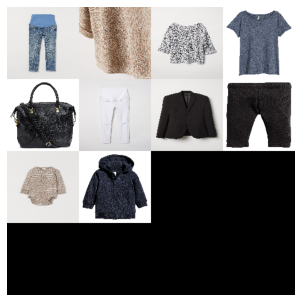

In [8]:
docs.plot_image_sprites() # Preview the images

## 4. Preprocess Data

In [9]:
# Convert to tensor, normalize so they're all similar enough
def preproc(d: Document):
    return (d.load_uri_to_image_tensor()  # load
             .set_image_tensor_shape((80, 60))  # ensure all images right size (dataset image size _should_ be (80, 60))
             .set_image_tensor_normalization()  # normalize color 
             .set_image_tensor_channel_axis(-1, 0))  # switch color axis for the PyTorch model later

In [10]:
# apply en masse
docs.apply(preproc)

                       Documents Summary                       
                                                               
  Length                 10                                    
  Homogenous Documents   True                                  
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri')  
                                                               
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  id          ('str',)       10               False            
  mime_type   ('str',)       1                False            
  tensor      ('ndarray',)   10               False            
  uri         ('str',)       10               False            
                                                               
                 Storage Summary                  
                                                  
  Backend                  Weaviate               
  Hostname                 http://localhost:8080  
  Schema Name              Image                  
  Serialization Protocol

## 5. Embed images

In [11]:
%pip install torchvision==0.11.2

Note: you may need to restart the kernel to use updated packages.


In [12]:
# Use GPU if available
import torch
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [13]:
import torchvision
model = torchvision.models.resnet50(pretrained=True)  # load ResNet50

In [14]:
docs.embed(model, device=device)

                             Documents Summary                              
                                                                            
  Length                 10                                                 
  Homogenous Documents   True                                               
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri', 'embedding')  
                                                                            
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  embedding   ('Tensor',)    10               False            
  id          ('str',)       10               False            
  mime_type   ('str',)       1                False            
  tensor      ('str',)       10               False            
  uri         ('ndarray',)   10               False            
                                                               
                 Storage Summary                  
                                                  
  Backend                  Weaviate               
  Hostname                 http://localhost:8080  
  Schema Name              Image                  
  Serialization Protocol

## 6. Query dataset

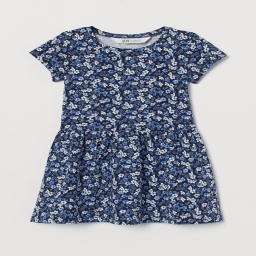

In [15]:
query_doc = Document(uri=QUERY_IMAGE)
query_doc.display()


In [21]:
query_docs = DocumentArray([query_doc])

In [22]:
query_docs.apply(preproc)

                       Documents Summary                       
                                                               
  Length                 1                                     
  Homogenous Documents   True                                  
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri')  
                                                               
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  id          ('str',)       1                False            
  mime_type   ('str',)       1                False            
  tensor      ('ndarray',)   1                False            
  uri         ('str',)       1                False

In [23]:
query_docs.embed(model, device=device) # If running on non-gpu machine, change "cuda" to "cpu"

                             Documents Summary                              
                                                                            
  Length                 1                                                  
  Homogenous Documents   True                                               
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri', 'embedding')  
                                                                            
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  embedding   ('Tensor',)    1                False            
  id          ('str',)       1                False            
  mime_type   ('str',)       1                False            
  tensor      ('str',)       1                False            
  uri         ('ndarray',)   1                False

In [24]:
docs.match(query_docs)

UnexpectedStatusCodeException: Get object/s! Unexpected status code: 400, with response body: {'error': [{'message': "no object with id '5cb6c86a-ceac-5954-ba0c-2bde722eb8bc'"}]}

In [ ]:
(DocumentArray(query_doc.matches, copy=True)
    .apply(lambda d: d.set_image_tensor_channel_axis(0, -1)
                      .set_image_tensor_inv_normalization())).plot_image_sprites()